#### Update met_em with current met_em + ( future_climate - Current_climate)
- Calcuate past, current and future climate (average) 
- Calculate the differences of
  - past and current climate  
  - future and current climate
- Update the met_em files by adding the differences
- Quick check the results

Ming Ge Nov 2024

In [1]:
import glob
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def cal_avg(dir_d, flnm_0):
    '''
    calculate the average of 5 thermal variables of met_em
    GHT, TT, RH, SST, SKINTEMP
    cal_avg('/met_em_data_dir/', 'met_em.d*.1946-0*.nc')
    '''
    
    flnm_1d = sorted(glob.glob(dir_d + flnm_0))
    n_file = len(flnm_1d)
    #print(dir_d + flnm_0)
    is_first = True
    for nf in range(n_file):
        flnm = flnm_1d[nf]
        #print(flnm)
        with xr.open_dataset(flnm) as ds:
            if is_first == True:
                GHT = ds.GHT.copy(deep=True)
                TT  = ds.TT.copy(deep=True)
                RH  = ds.RH.copy(deep=True)
                SST = ds.SST.copy(deep=True)
                SKINTEMP = ds.SKINTEMP.copy(deep=True)
                is_first = False
                
            else:
                GHT.values = GHT.values + ds.GHT.values
                TT.values  = TT.values +  ds.TT.values
                RH.values  = RH.values +  ds.RH.values
                SST.values = SST.values + ds.SST.values
                SKINTEMP.values = SKINTEMP.values + ds.SKINTEMP.values

    GHT.values = GHT.values/float(n_file)
    TT.values  = TT.values/float(n_file)
    RH.values  = RH.values/float(n_file)
    SST.values = SST.values/float(n_file)
    SKINTEMP.values = SKINTEMP.values/float(n_file)
    return GHT, TT, RH, SST, SKINTEMP


In [3]:
def update_met_em(dir_old, dir_new, dom_s, GHT_d, TT_d, RH_d, SST_d, SKINTEMP_d):
     
    len_dir = len(dir_old)
    flnm_1d = sorted(glob.glob(dir_old + 'met_em.d' + dom_s + '.*nc'))
    n_file = len(flnm_1d)
    # James has a bad file
    flnm_bad = '/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/met_em.d01.2021-08-24_00:00:00.nc'
    for flnm in flnm_1d:
        if flnm != flnm_bad:
            flnm_o = dir_new + flnm[len_dir:]
    
            with xr.open_dataset(flnm) as ds:
                ds.GHT.values = ds.GHT.values + GHT_d
                ds.TT.values = ds.TT.values + TT_d  
                ds.RH.values = ds.RH.values + RH_d  
                ds.SST.values = ds.SST.values + SST_d  
                ds.SKINTEMP.values = ds.SKINTEMP.values + SKINTEMP_d 
            #print(flnm_o)
            ds.to_netcdf(flnm_o) # rewrite to netcdf    

In [33]:
def ax_coastlines_country(ax_s):
    ax_s.coastlines(lw=1.5, resolution='110m')
    ax_s.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=1.5, edgecolor='g')
    # mask ocean 
    #ax_s.add_feature(cfeature.OCEAN, facecolor='white', zorder=1) 

def plot_p2(lat, lon, data_3d, color_map, level_s, title_s):
    fig = plt.figure(figsize=(22, 12))

    vmin = 0
     
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}
    
    for nf in range(1, 3):
        ax = fig.add_subplot(1, 2, nf, projection= ccrs.PlateCarree())

        if nf == 1:
            vmax = 50
        else: 
            vmax = 10
        #level_s = np.linspace(vmin, vmax, 11) 
        
        mm = plt.contourf(lon, lat, data_3d[nf-1], 
                      cmap = color_map, extend='both',
                      levels = level_s,
                      transform=ccrs.PlateCarree())
        
        ax.coastlines()
        ax_coastlines_country(ax)
        
        plt.colorbar(mm, orientation='horizontal', pad=0.05)    
     
        gl = ax.gridlines(draw_labels=True)   
        gl.xlines = gl.ylines = False
        if nf == 1:
            plt.title(title_s + ' (past looking - original)', fontweight="bold",fontsize=14)
        else:
            plt.title(title_s + ' (forward looking - original)', fontweight="bold",fontsize=14)


#### Calcuate current and future climate (average)

In [10]:
%%time

dom_s = '02'

dir_past    = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Past/'
dir_current = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Current/'
dir_future  = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Future/'

var_s_1d = ['GHT', 'TT', 'RH', 'SST', 'SKINTEMP']
print('past')
GHT_p, TT_p, RH_p, SST_p, SKINTEMP_p = cal_avg(dir_past,    'met_em.d' + dom_s + '.1956-0*.nc')
print('current')
GHT_c, TT_c, RH_c, SST_c, SKINTEMP_c = cal_avg(dir_current, 'met_em.d' + dom_s + '.2006-0*.nc')
print('future')
GHT_f, TT_f, RH_f, SST_f, SKINTEMP_f = cal_avg(dir_future,  'met_em.d' + dom_s + '.2056-0*.nc')

past
current
future
CPU times: user 11min 54s, sys: 1min 37s, total: 13min 31s
Wall time: 17min 54s


- Calculate the differences between past & future climate and current climate

In [11]:
GHT_df_p = GHT_p - GHT_c
TT_df_p  = TT_p - TT_c
RH_df_p  = RH_p - RH_c
SST_df_p = SST_p - SST_c
SKINTEMP_df_p = SKINTEMP_p - SKINTEMP_c

GHT_df_f      = GHT_f - GHT_c
TT_df_f       = TT_f - TT_c
RH_df_f       = RH_f - RH_c
SST_df_f      = SST_f - SST_c
SKINTEMP_df_f = SKINTEMP_f - SKINTEMP_c

- Update  simulation

In [12]:
%%time
dir_old = '/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/'
dir_backward = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Backward/'
dir_forward  = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Forward/'

update_met_em(dir_old, dir_backward, dom_s, GHT_df_p, TT_df_p, RH_df_p, SST_df_p, SKINTEMP_df_p)
update_met_em(dir_old, dir_forward,  dom_s, GHT_df_f, TT_df_f, RH_df_f, SST_df_f, SKINTEMP_df_f)

CPU times: user 1h 1min 25s, sys: 2min 28s, total: 1h 3min 53s
Wall time: 1h 10min 17s


#### Quick check the results
- Domain 1

/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Backward/met_em.d01.2021-08-26_12:00:00.nc
/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Forward/met_em.d01.2021-08-26_12:00:00.nc
/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/met_em.d01.2021-08-26_12:00:00.nc
GHT
TT
RH
SST
SKINTEMP


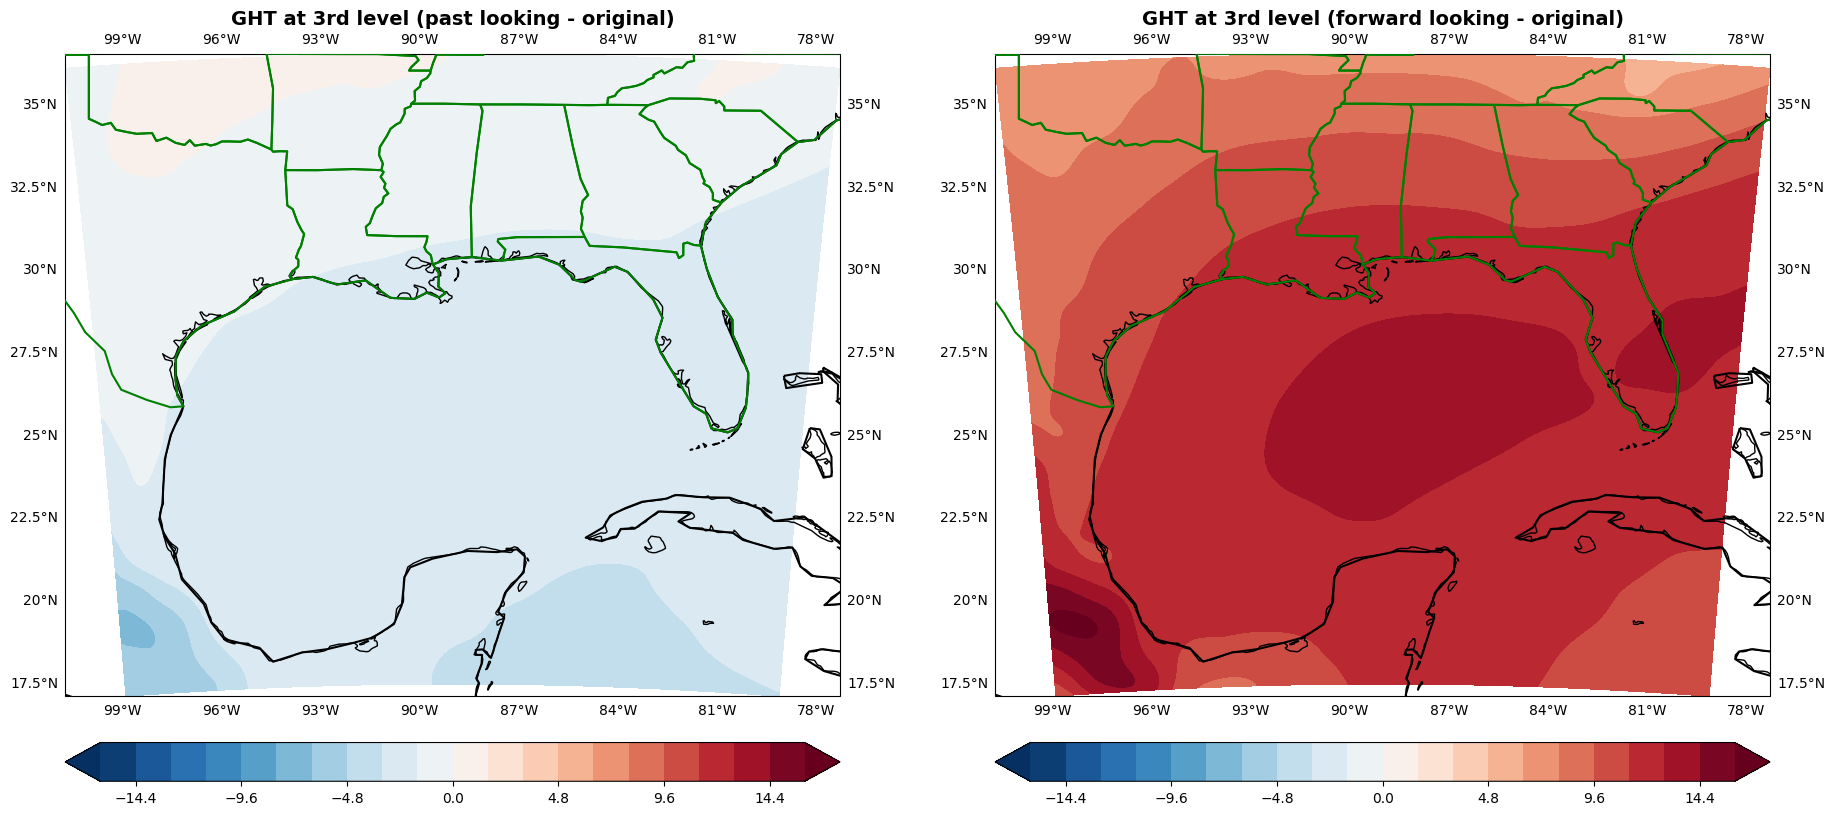

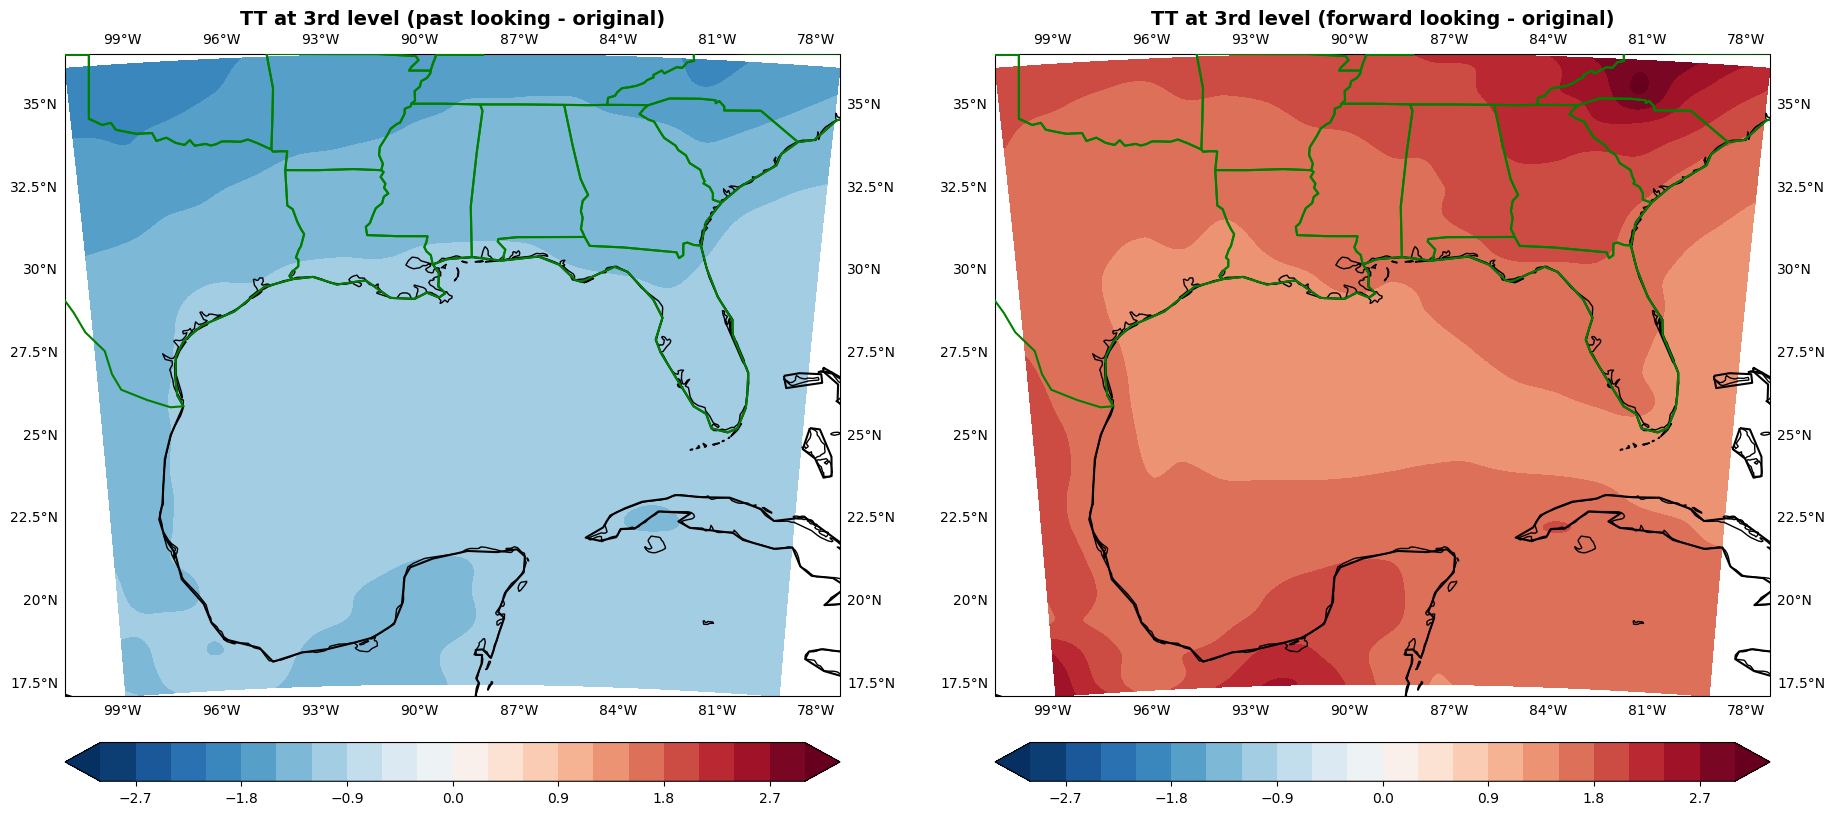

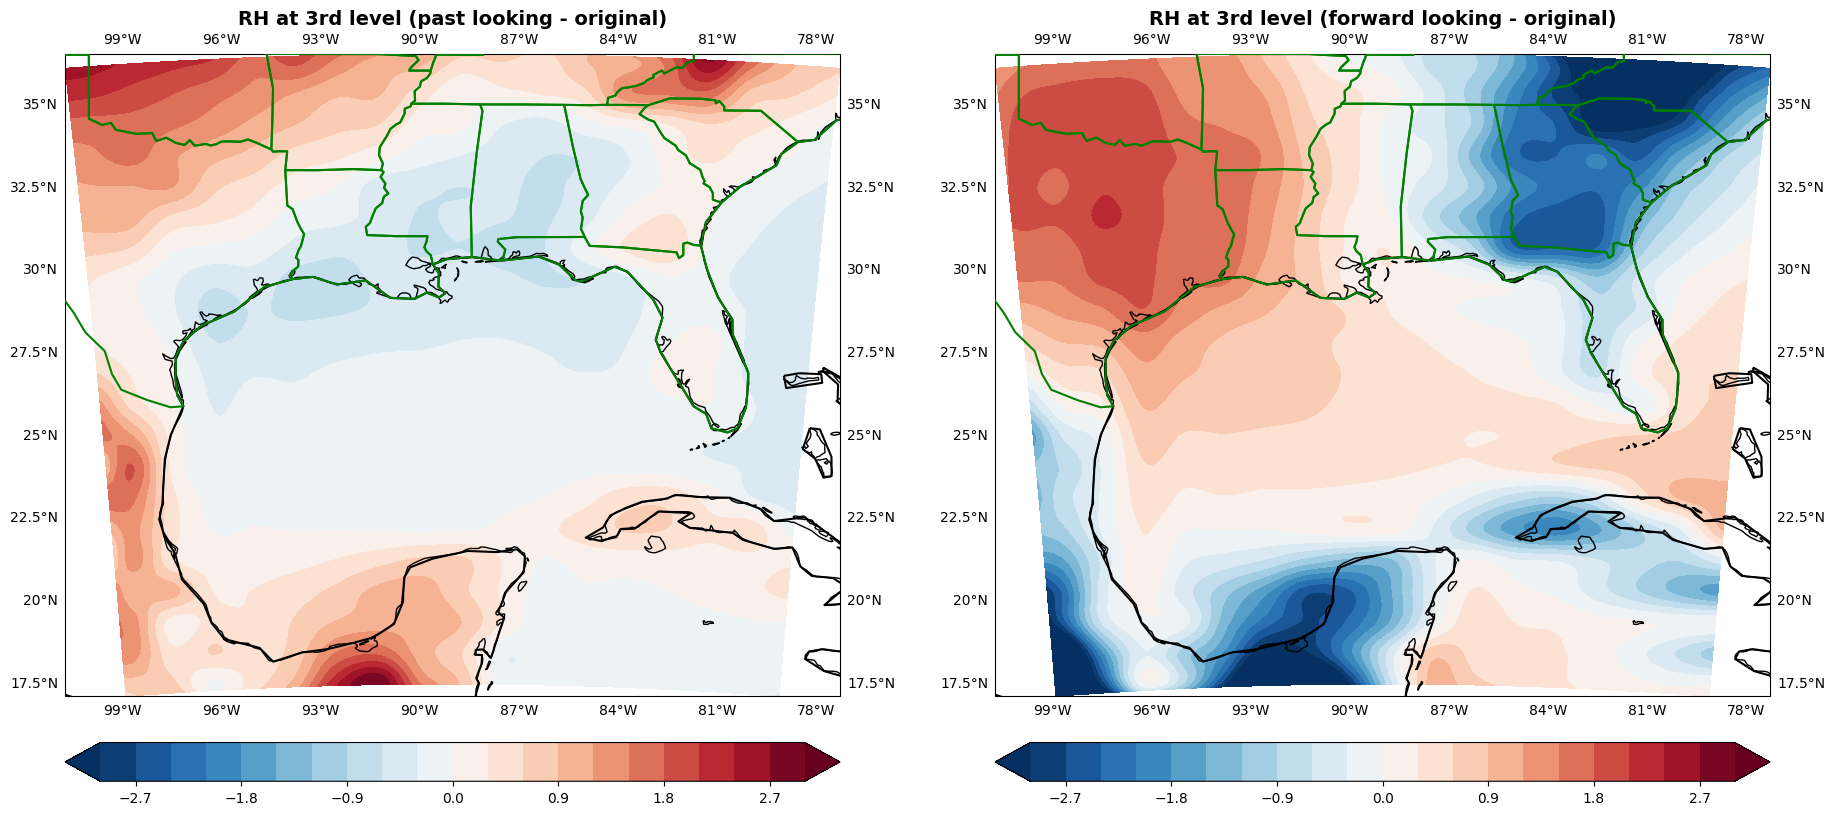

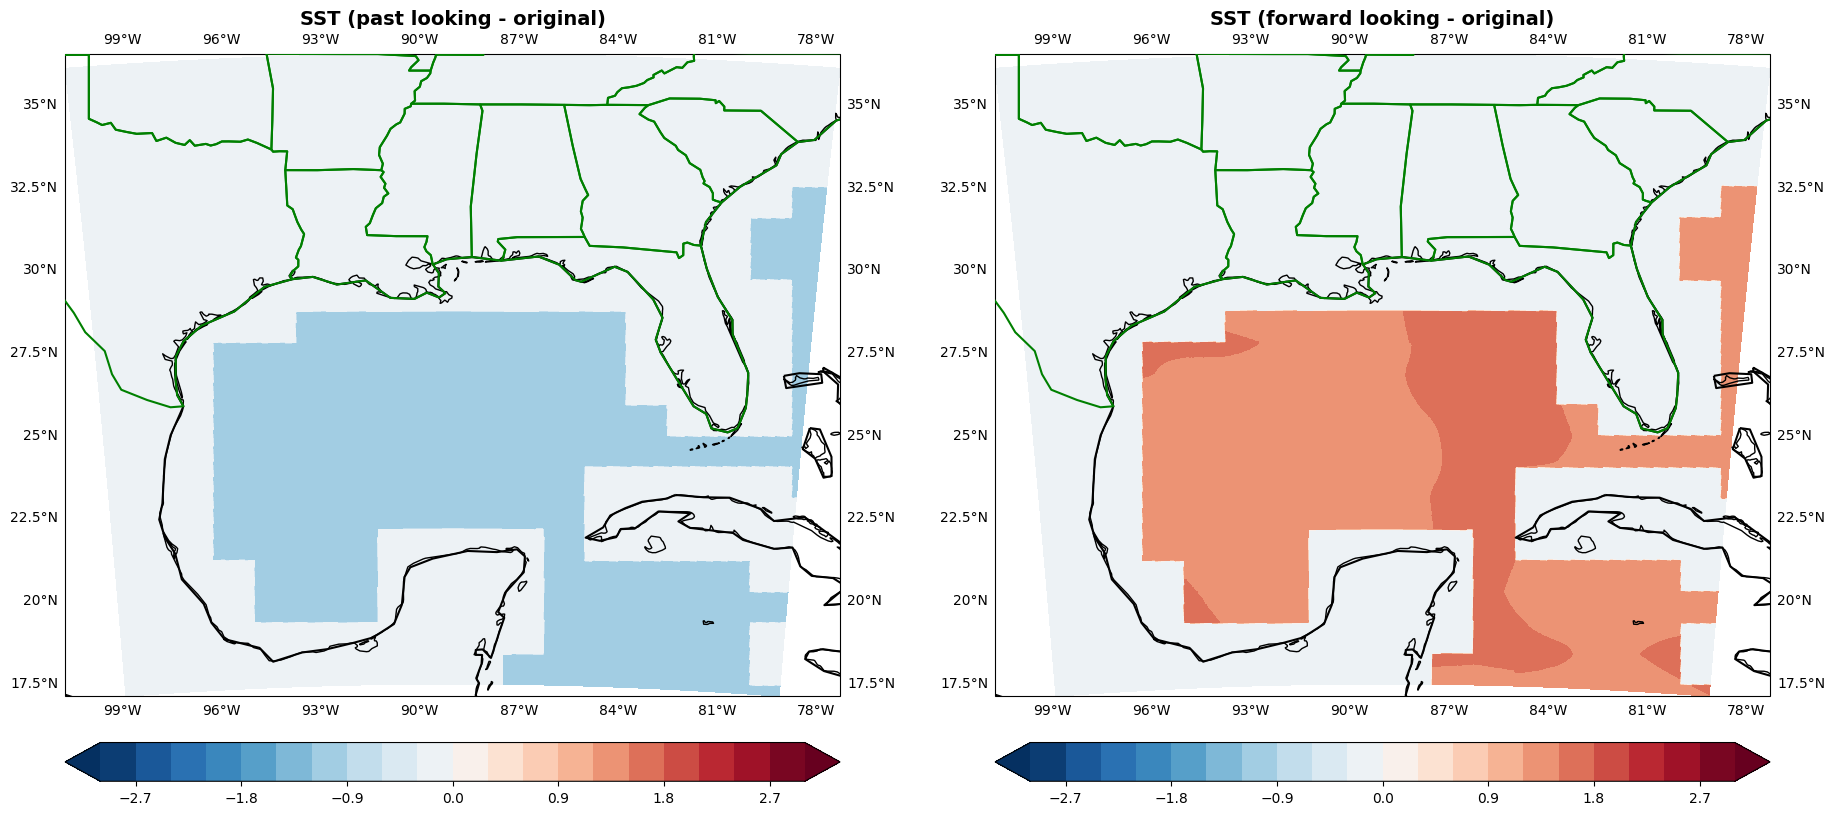

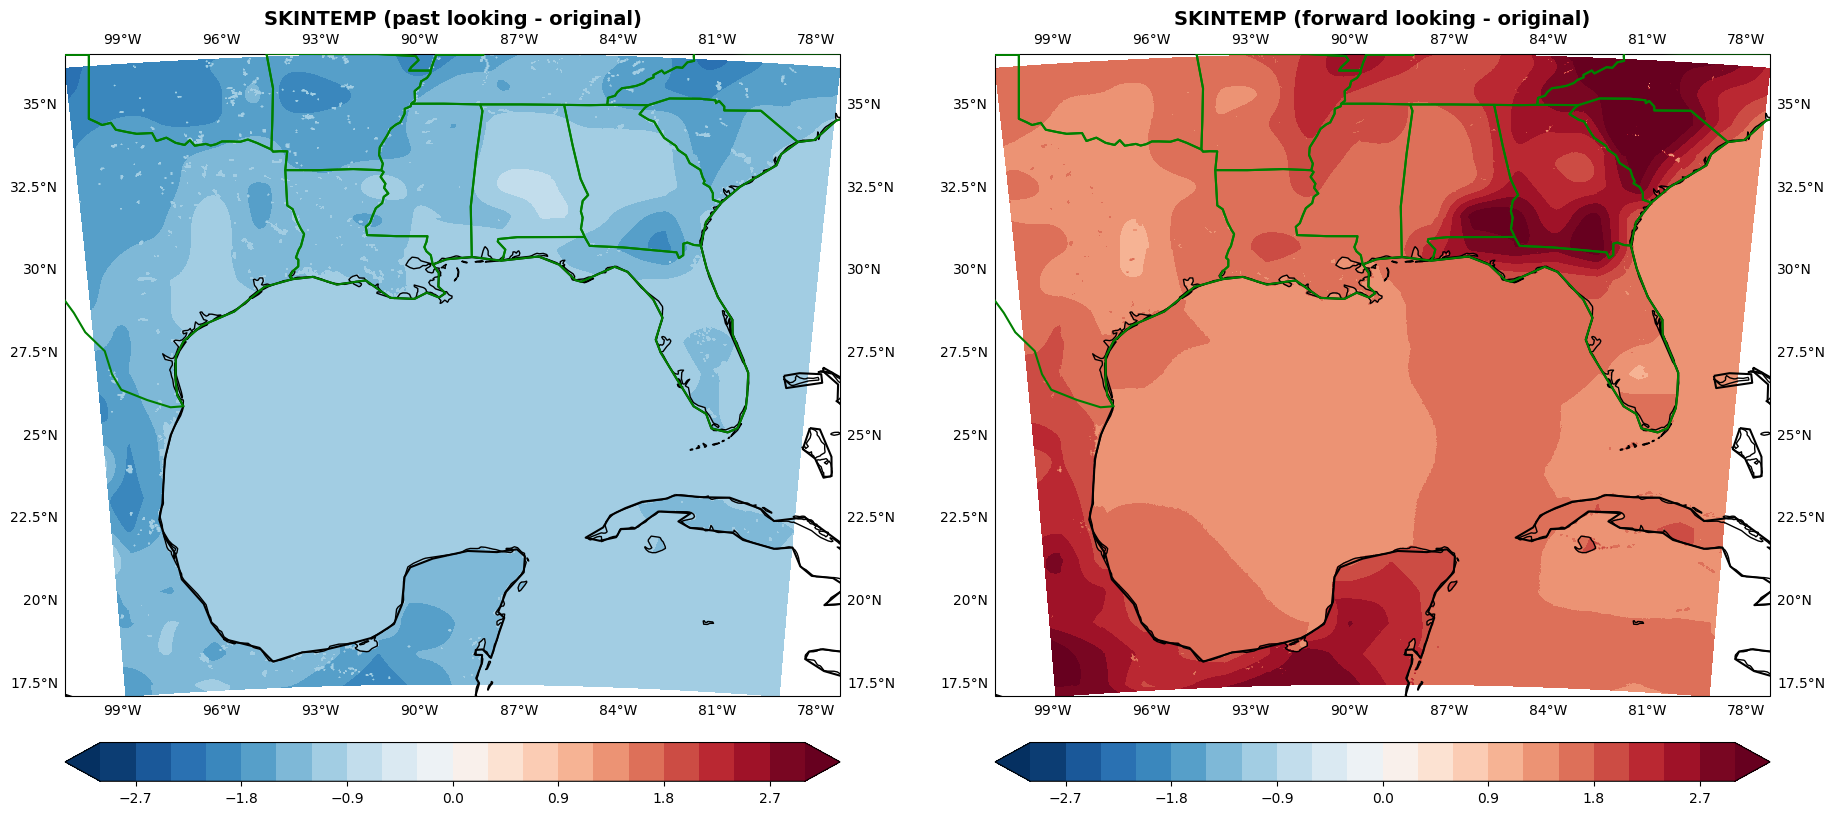

In [43]:
dir_old = '/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/'

dom_s = '01'
flnm = 'met_em.d' + dom_s +'.2021-08-26_12:00:00.nc'
 
flnm_backward = dir_backward + flnm
flnm_forward  = dir_forward + flnm
flnm_old = dir_old + flnm

print(flnm_backward)
print(flnm_forward)
print(flnm_old)

for nv in range(len(var_s_1d)):
    print(var_s_1d[nv])
    with xr.open_dataset(flnm_old) as ds_old:
        TT_old = ds_old[var_s_1d[nv]][0]
    with xr.open_dataset(flnm_backward) as ds_backward:
        TT_b = ds_backward[var_s_1d[nv]][0]
    with xr.open_dataset(flnm_forward) as ds_forward:
        TT_f = ds_forward[var_s_1d[nv]][0] 
        
    if nv == 0:
        lat_2d = ds_old.XLAT_M[0]
        lon_2d = ds_old.XLONG_M[0]
        data_3d = np.zeros((2, lat_2d.shape[0], lat_2d.shape[1]))
        
    if var_s_1d[nv] == 'SST' or var_s_1d[nv] == 'SKINTEMP':
        data_3d[0] = TT_b - TT_old
        data_3d[1] = TT_f - TT_old
        
    else:
        data_3d[0] = TT_b[2] - TT_old[2]
        data_3d[1] = TT_f[2] - TT_old[2]
        
    if var_s_1d[nv] == 'GHT':
        level_s = np.linspace(-16, 16, 21) 
    else:
        level_s = np.linspace(-3, 3, 21)        
        
    if var_s_1d[nv] == 'SST' or var_s_1d[nv] == 'SKINTEMP':    
        plot_p2(lat_2d, lon_2d, data_3d, 'RdBu_r', level_s, var_s_1d[nv])
    else:
        plot_p2(lat_2d, lon_2d, data_3d, 'RdBu_r', level_s, var_s_1d[nv] + ' at 3rd level')

/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Backward/met_em.d02.2021-08-26_12:00:00.nc
/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Forward/met_em.d02.2021-08-26_12:00:00.nc
/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/met_em.d02.2021-08-26_12:00:00.nc
GHT
TT
RH
SST
SKINTEMP


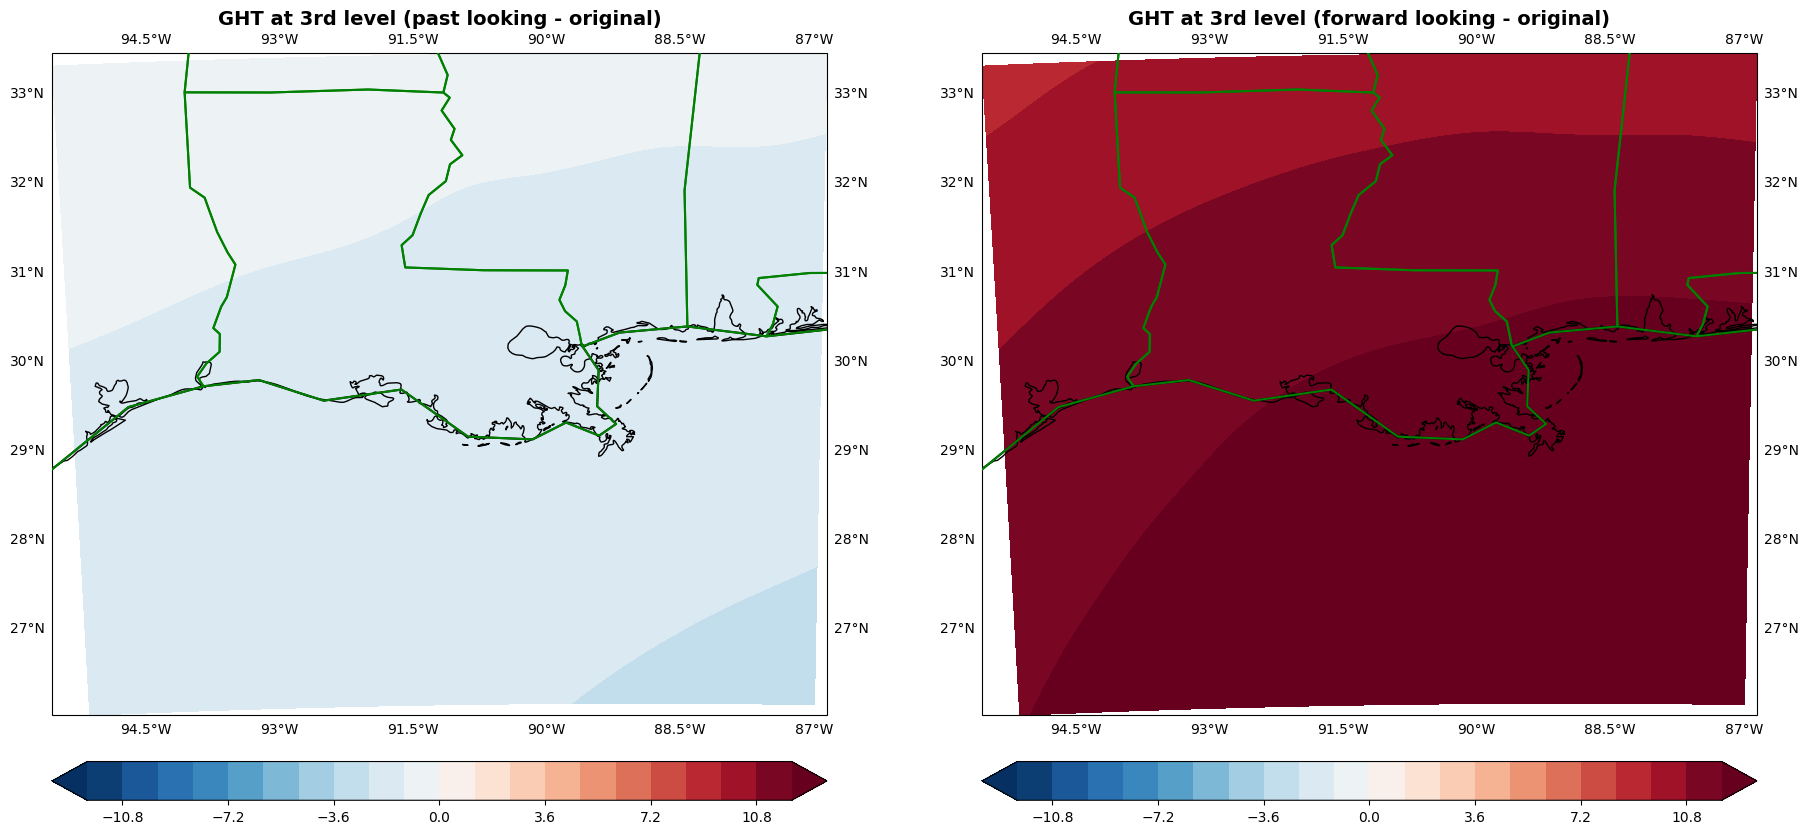

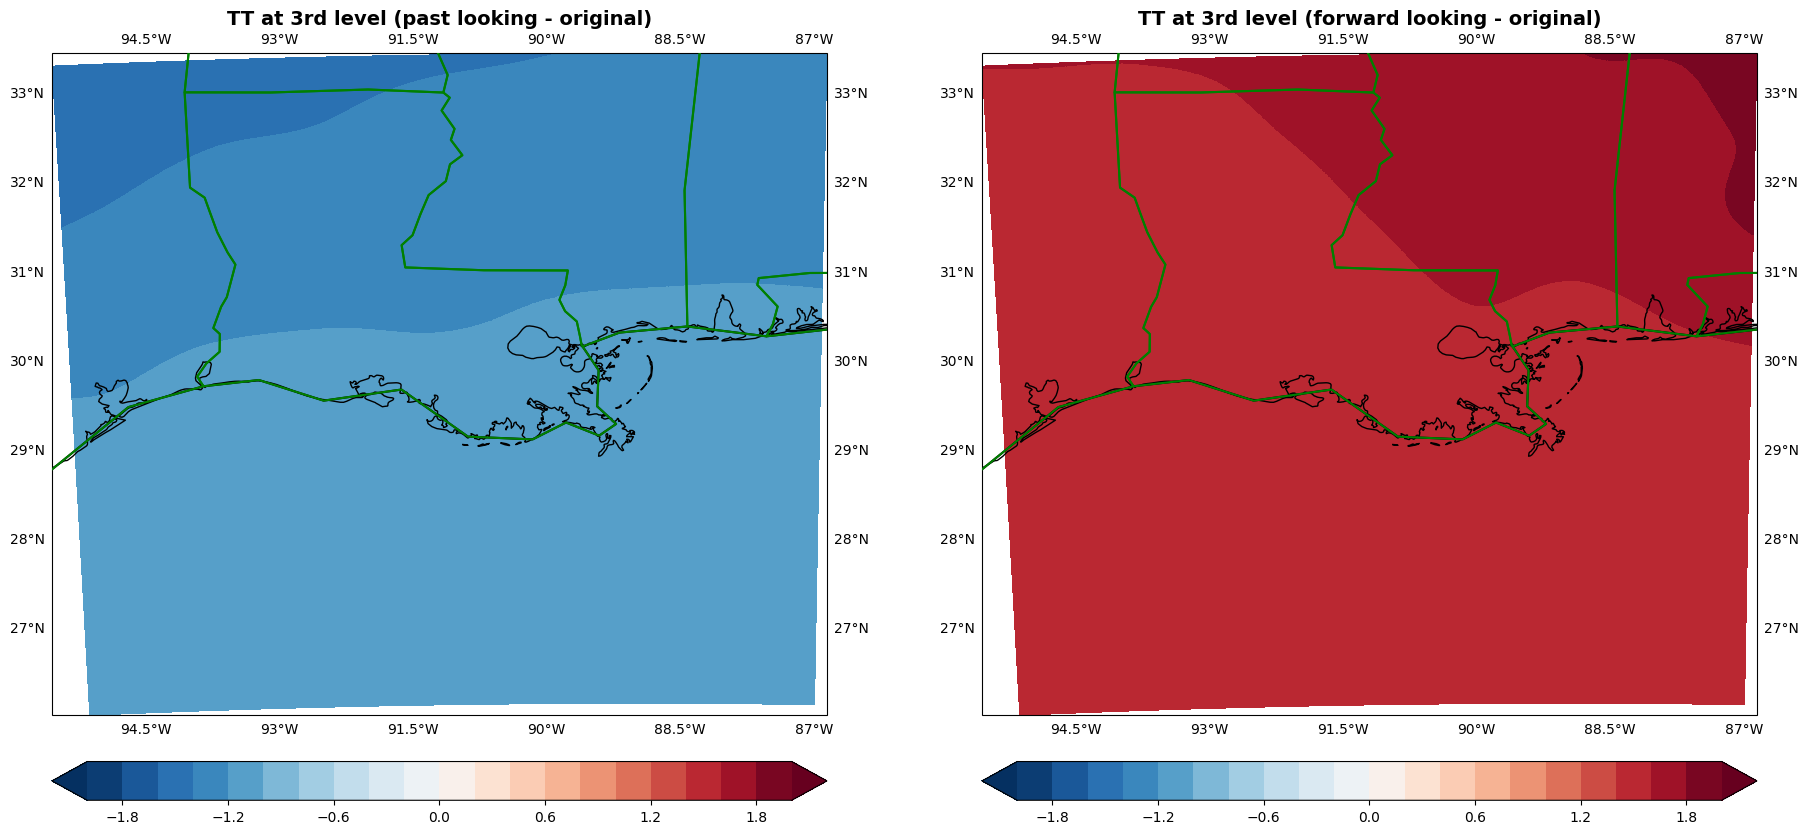

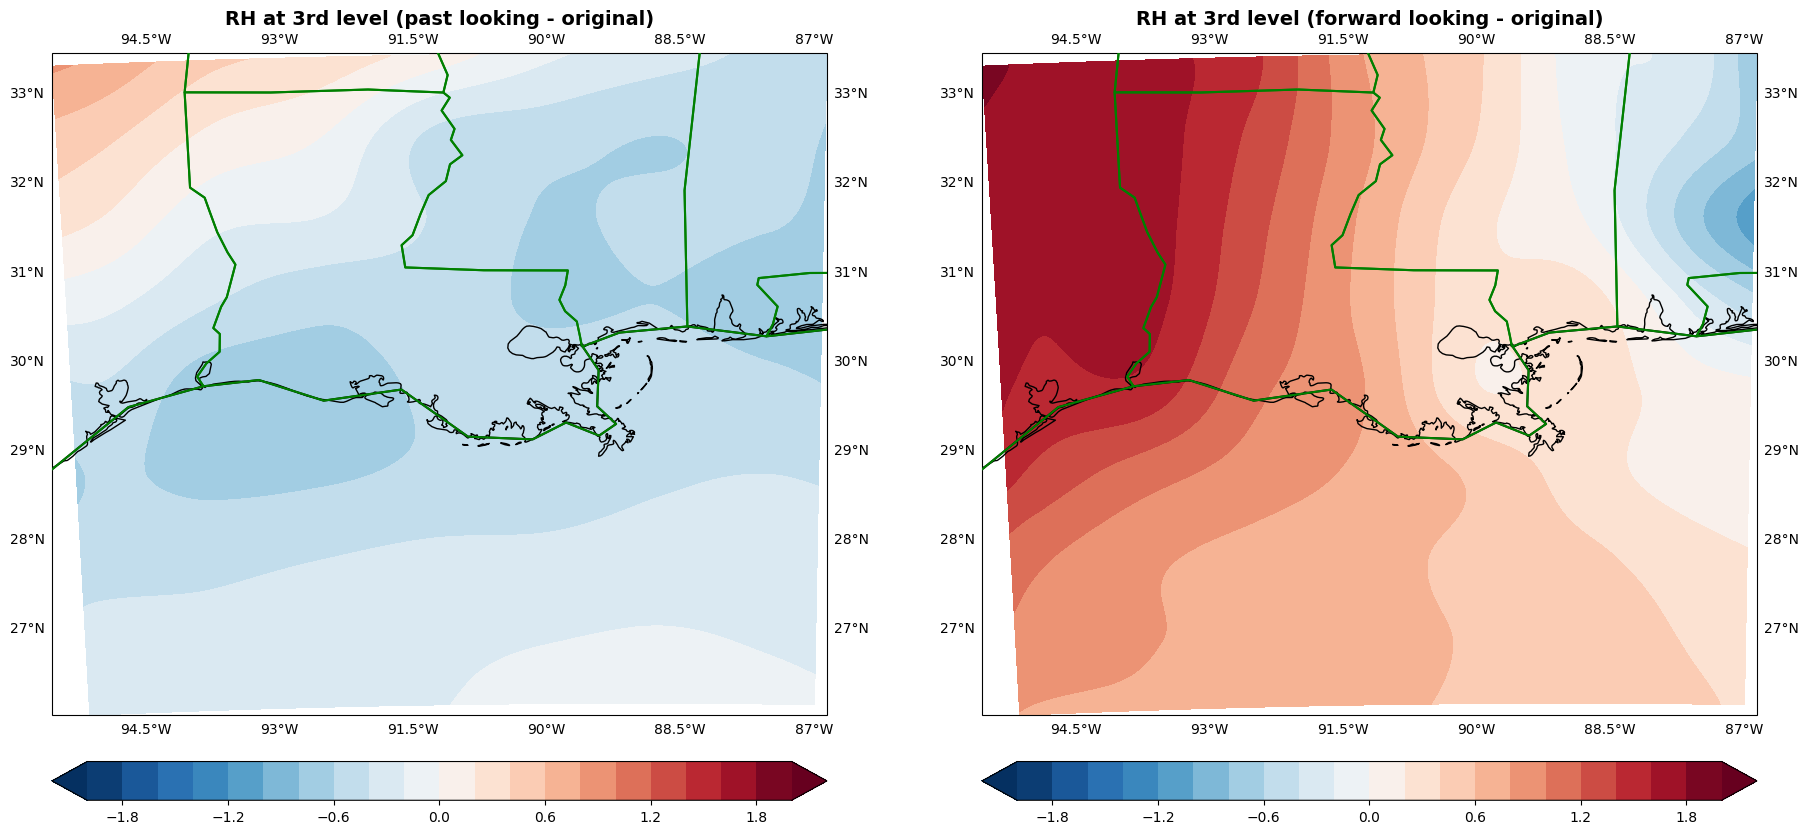

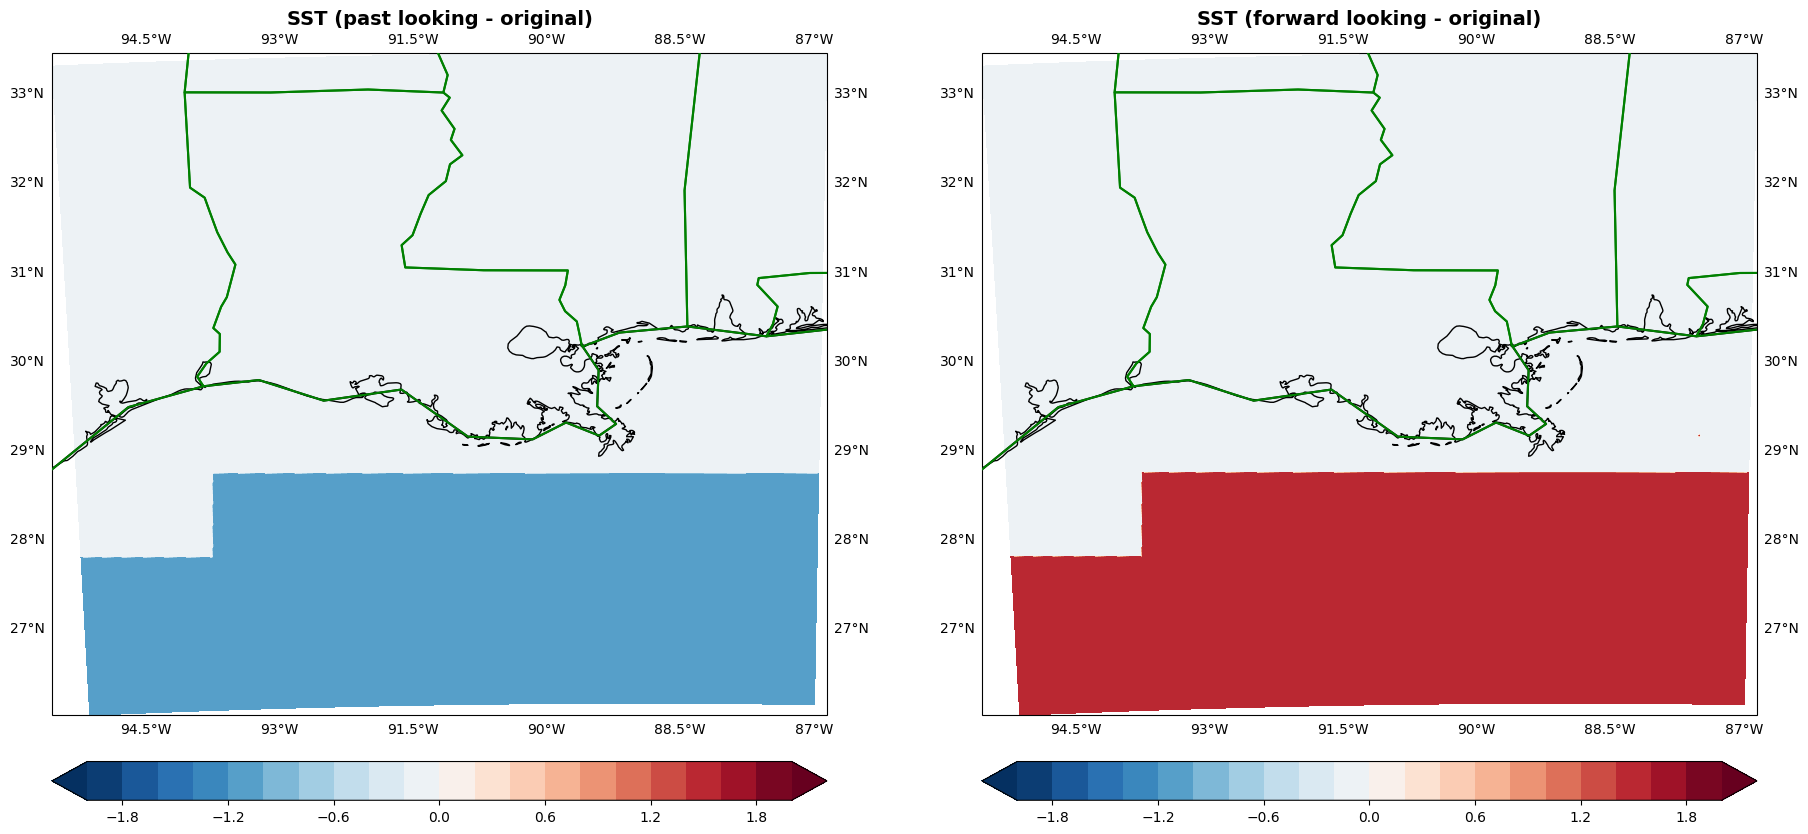

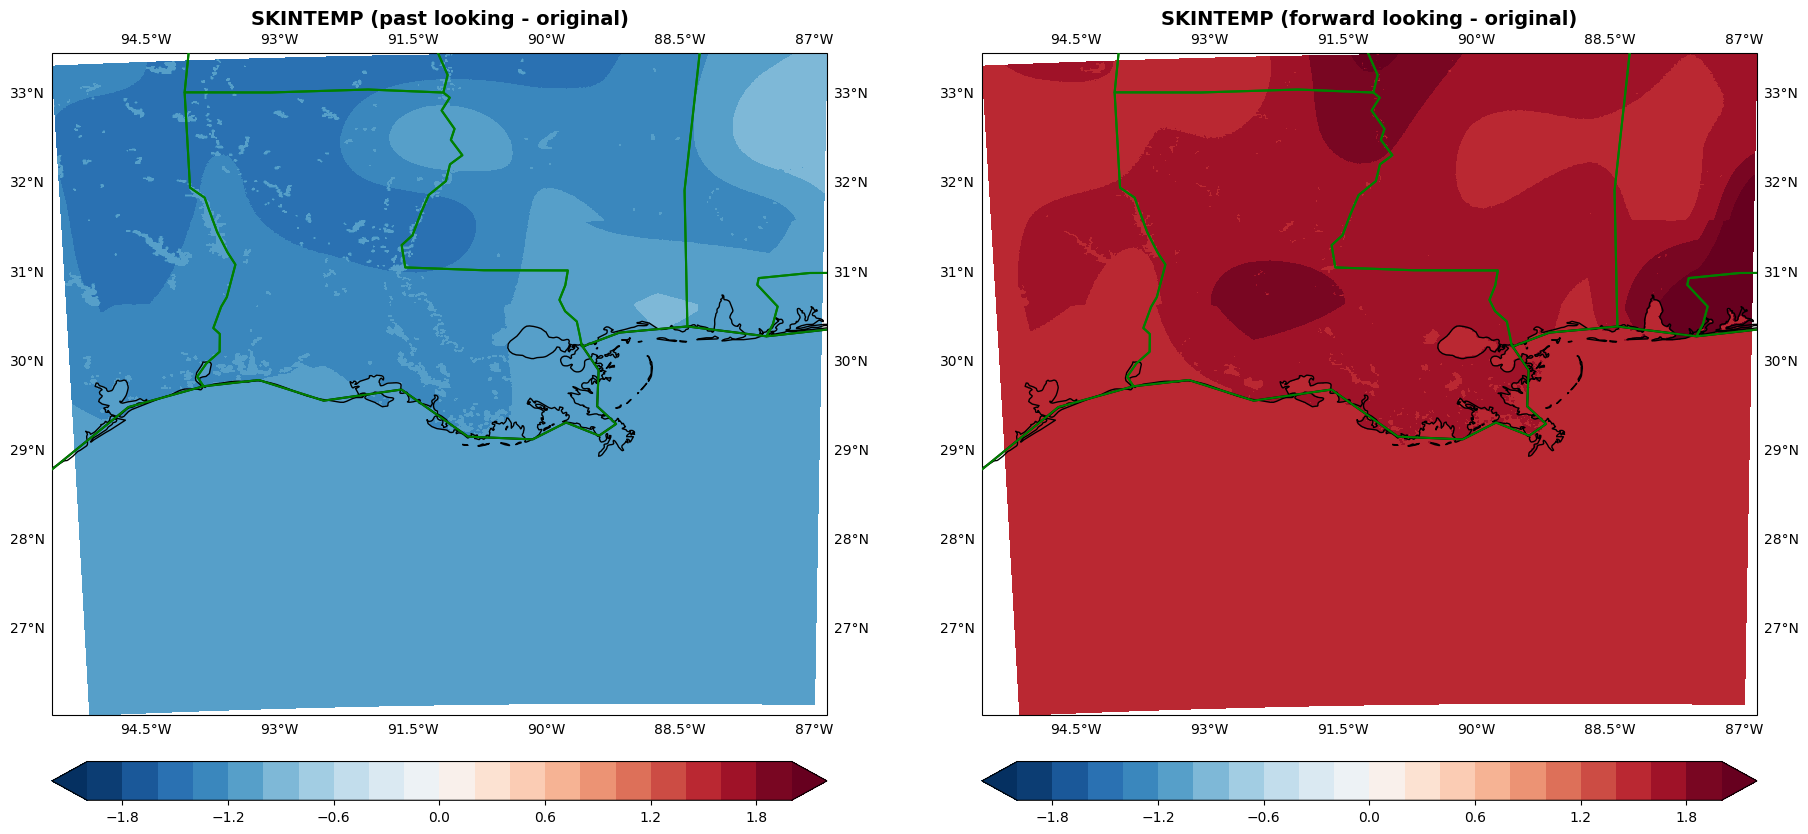

In [44]:
dir_old = '/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/'

dom_s = '02'
flnm = 'met_em.d' + dom_s +'.2021-08-26_12:00:00.nc'
 
flnm_backward = dir_backward + flnm
flnm_forward  = dir_forward + flnm
flnm_old = dir_old + flnm

print(flnm_backward)
print(flnm_forward)
print(flnm_old)

for nv in range(len(var_s_1d)):
    print(var_s_1d[nv])
    with xr.open_dataset(flnm_old) as ds_old:
        TT_old = ds_old[var_s_1d[nv]][0]
    with xr.open_dataset(flnm_backward) as ds_backward:
        TT_b = ds_backward[var_s_1d[nv]][0]
    with xr.open_dataset(flnm_forward) as ds_forward:
        TT_f = ds_forward[var_s_1d[nv]][0] 
        
    if nv == 0:
        lat_2d = ds_old.XLAT_M[0]
        lon_2d = ds_old.XLONG_M[0]
        data_3d = np.zeros((2, lat_2d.shape[0], lat_2d.shape[1]))
        
    if var_s_1d[nv] == 'SST' or var_s_1d[nv] == 'SKINTEMP':
        data_3d[0] = TT_b - TT_old
        data_3d[1] = TT_f - TT_old
        
    else:
        data_3d[0] = TT_b[2] - TT_old[2]
        data_3d[1] = TT_f[2] - TT_old[2]
        
    if var_s_1d[nv] == 'GHT':
        level_s = np.linspace(-12, 12, 21) 
    else:
        level_s = np.linspace(-2, 2, 21)        
        
    if var_s_1d[nv] == 'SST' or var_s_1d[nv] == 'SKINTEMP':    
        plot_p2(lat_2d, lon_2d, data_3d, 'RdBu_r', level_s, var_s_1d[nv])
    else:
        plot_p2(lat_2d, lon_2d, data_3d, 'RdBu_r', level_s, var_s_1d[nv] + ' at 3rd level')